<a href="https://colab.research.google.com/github/data-better/ASL/blob/master/11%EA%B0%95_date_formatter_att_mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [ ]:
!pip install mxnet-cu100

In [ ]:
!pip install gluon

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
from mxnet.ndarray.linalg import gemm2
import datetime
from datetime import datetime

In [ ]:
def padding(chars, maxlen):
    if len(chars) < maxlen:
        return chars + ' ' * (maxlen - len(chars))
    else:
        return chars[:maxlen]

def gen_date():
    rnd = int(np.random.uniform(low = 1000000000, high = 1350000000))
    timestamp = datetime.fromtimestamp(rnd)
    return str(timestamp.strftime('%Y-%B-%d %a')) # '%Y-%B-%d %H:%M:%S'

def format_date(x):
    return str(datetime.strptime(x, '%Y-%B-%d %a').strftime('%m/%d/%Y, %A')).lower() #'%H%M%S:%Y%m%d'

N = 1000
N_train = int(N * .9)
N_validation = N - N_train

in_seq_len = 32
out_seq_len = 32

added = set()
questions = []
answers = []
answers_y = []

while len(questions) < N:
    if len(questions) % 1000 == 0:
        print('i = {}'.format(len(questions)))
    a = gen_date()
    if a in added:
        continue
    question = '[{}]'.format(a)
    answer = '[' + str(format_date(a)) + ']'
    answer = padding(answer, out_seq_len)
    answer_y = str(format_date(a)) + ']'
    answer_y = padding(answer_y, out_seq_len)
    
    added.add(a)
    questions.append(question)
    answers.append(answer)
    answers_y.append(answer_y)

chars = list(set(''.join(questions[:20000])))
chars.extend(['[', ']']) # Start and End of Expression
chars.extend(list(set(''.join(answers[:20000]))))
chars = np.sort(list(set(chars)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

i = 0


In [ ]:
print(questions[:10])
print(answers[:10])

['[2009-March-06 Fri]', '[2004-January-17 Sat]', '[2006-February-10 Fri]', '[2003-January-04 Sat]', '[2011-February-14 Mon]', '[2002-March-08 Fri]', '[2010-July-31 Sat]', '[2004-January-31 Sat]', '[2008-June-08 Sun]', '[2002-July-02 Tue]']
['[03/06/2009, friday]            ', '[01/17/2004, saturday]          ', '[02/10/2006, friday]            ', '[01/04/2003, saturday]          ', '[02/14/2011, monday]            ', '[03/08/2002, friday]            ', '[07/31/2010, saturday]          ', '[01/31/2004, saturday]          ', '[06/08/2008, sunday]            ', '[07/02/2002, tuesday]           ']


In [ ]:
X = np.zeros((len(questions), in_seq_len, len(chars)), dtype=np.integer)
Y = np.zeros((len(questions), out_seq_len, len(chars)), dtype=np.integer)
Z = np.zeros((len(questions), out_seq_len, len(chars)), dtype=np.integer)

for i in range(N):
    for t, char in enumerate(questions[i]):
        X[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers[i]):
        Y[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers_y[i]):
        Z[i, t, char_indices[char]] = 1
    
X_train, X_validation, Y_train, Y_validation, Z_train, Z_validation = \
    train_test_split(X, Y, Z, train_size=N_train)

### Testset

In [ ]:
def gen_test(N):
    q = []
    y = []
    
    for i in range(N):
        question = gen_date()
        answer_y = format_date(question)
        q.append(question)
        y.append(answer_y)
    return(q,y)

In [ ]:
gen_test(2)

(['2004-September-30 Thu', '2010-August-27 Fri'],
 ['09/30/2004, thursday', '08/27/2010, friday'])

In [ ]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [ ]:
class pattern_matcher(gluon.Block):
    def __init__(self, n_hidden, in_seq_len, out_seq_len, vocab_size, ctx, **kwargs):
        super(pattern_matcher, self).__init__(**kwargs)
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.n_hidden = n_hidden
        self.vocab_size = vocab_size
        
        with self.name_scope():
            self.encoder = rnn.LSTMCell(hidden_size = n_hidden)
            self.decoder = rnn.LSTMCell(hidden_size = n_hidden)
            self.attn_weight = nn.Dense(self.in_seq_len, in_units = self.in_seq_len)            
            self.batchnorm = nn.BatchNorm(axis = 2)
            self.dense = nn.Dense(self.vocab_size, flatten = False)
            
    def forward(self, inputs, outputs):
        self.batch_size = inputs.shape[0]
        enout, (next_h, next_c) = self.encoder.unroll(inputs = inputs \
                                                    , length = self.in_seq_len \
                                                    , merge_outputs = True)
        # enout: (n_batch * time_step * n_hidden), next_h, next_c: (n_batch * n_hidden)
        for i in range(self.out_seq_len):
            # For each time step, caclculate context for attention
            _n_h = next_h.expand_dims(axis = 2)
            ####### Attention part: To get context vector at jth point of output sequence
            score_i = gemm2(enout, next_h.expand_dims(axis = 2))  # n_batch * time_step * 1
            alpha_i = nd.softmax(self.attn_weight(score_i)) # n_batch * time_step
            alpha_expand = alpha_i.expand_dims(2) # (n_batch * 1 * time_step)
            alpha_expand = nd.repeat(alpha_expand,repeats= self.n_hidden, axis=2) # n_batch * time_step * n_hidden
            context = nd.multiply(alpha_expand, enout) # n_batch * time_step * n_hidden
            context = nd.sum(context, axis = 1) # n_batch * n_hidden
            _in = nd.concat(outputs[:, i, :], context)
            deout, (next_h, next_c) = self.decoder(_in, [next_h, next_c],)
            if i == 0:
                deouts = deout
            else:
                deouts = nd.concat(deouts, deout, dim = 1)   
        deouts = nd.reshape(deouts, (-1, self.out_seq_len, self.n_hidden))
        deouts = self.batchnorm(deouts)
        deouts_fc = self.dense(deouts)
        return deouts_fc
    
    def predict(self, input_str, char_indices, indices_char, input_digits = 9, lchars = 14, ctx = mx.gpu()):
        # No label when evaluating new example. So try to put the result of the previous time step
        alpha = []
        input_str = '[' + input_str + ']'
        X = nd.zeros((1, input_digits, lchars), ctx = ctx)
        for t, char in enumerate(input_str):
            X[0, t, char_indices[char]] = 1
        Y_init = nd.zeros((1, lchars), ctx = ctx)
        Y_init[0, char_indices['[']] = 1
        enout, (next_h, next_c) = self.encoder.unroll(inputs = X, length = self.in_seq_len, merge_outputs = True)
        deout = Y_init
        
        for i in range(self.out_seq_len):
            ####### Attention part: To get context vector at jth point of output sequence
            score_i = gemm2(enout, next_h.expand_dims(axis = 2))
            alpha_i = nd.softmax(self.attn_weight(score_i))
            alpha_expand = alpha_i.expand_dims(2)
            alpha_expand = nd.repeat(alpha_expand,repeats= self.n_hidden, axis=2) # n_batch * time step * n_hidden
            context = nd.multiply(alpha_expand, enout)
            context = nd.sum(context, axis = 1) # n_batch * n_hidden
            _in = nd.concat(deout, context)
            deout, (next_h, next_c) = self.decoder(_in, [next_h, next_c],)
            deout = nd.expand_dims(deout, axis = 1)
            deout = self.batchnorm(deout)
            deout = deout[:, 0, :]
            deout_sm = self.dense(deout)
            deout = nd.one_hot(nd.argmax(nd.softmax(deout_sm, axis = 1), axis = 1), depth = self.vocab_size)
            if i == 0:
                ret_seq = indices_char[nd.argmax(deout_sm, axis = 1).asnumpy()[0].astype('int')]
            else:
                ret_seq += indices_char[nd.argmax(deout_sm, axis = 1).asnumpy()[0].astype('int')]
            if ret_seq[-1] == ']':
                break
            alpha.append(alpha_i.asnumpy())
        return ret_seq.strip(']').strip(), np.squeeze(np.array(alpha), axis = 1)

In [ ]:
tr_set = gluon.data.ArrayDataset(X_train, Y_train, Z_train)
tr_data_iterator = gluon.data.DataLoader(tr_set, batch_size=256, shuffle=True)

te_set =gluon.data.ArrayDataset(X_validation, Y_validation, Z_validation)
te_data_iterator = gluon.data.DataLoader(te_set, batch_size=256, shuffle=True)

In [ ]:
ctx = mx.gpu()
model = pattern_matcher(300, in_seq_len, out_seq_len, len(chars), ctx)
model.collect_params().initialize(mx.init.Xavier(), ctx = ctx)

trainer = gluon.Trainer(model.collect_params(), 'rmsprop')
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis = 2, sparse_label = False)

In [ ]:
print(model)

pattern_matcher(
  (encoder): LSTMCell(None -> 1200)
  (decoder): LSTMCell(None -> 1200)
  (attn_weight): Dense(32 -> 32, linear)
  (batchnorm): BatchNorm(axis=2, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (dense): Dense(None -> 47, linear)
)


In [ ]:
def calculate_loss(model, data_iter, loss_obj, ctx = ctx):
    test_loss = []
    for i, (x_data, y_data, z_data) in enumerate(data_iter):
        x_data = x_data.as_in_context(ctx).astype('float32')
        y_data = y_data.as_in_context(ctx).astype('float32')
        z_data = z_data.as_in_context(ctx).astype('float32')
        with autograd.predict_mode():
            z_output = model(x_data, y_data)
            loss_te = loss_obj(z_output, z_data)
        curr_loss = nd.mean(loss_te).asscalar()
        test_loss.append(curr_loss)
    return np.mean(test_loss)

In [ ]:
epochs = 200

tot_test_loss = []
tot_train_loss = []
for e in range(epochs):
    train_loss = []
    for i, (x_data, y_data, z_data) in enumerate(tr_data_iterator):
        x_data = x_data.as_in_context(ctx).astype('float32')
        y_data = y_data.as_in_context(ctx).astype('float32')
        z_data = z_data.as_in_context(ctx).astype('float32')
        
        with autograd.record():
            z_output = model(x_data, y_data)
            loss_ = loss(z_output, z_data)
        loss_.backward()
        trainer.step(x_data.shape[0])
        curr_loss = nd.mean(loss_).asscalar()
        train_loss.append(curr_loss)
        
    if e % 10 == 0:
        q, y = gen_test(10)
        for i in range(10):
            with autograd.predict_mode():
                p, attn = model.predict(q[i], char_indices, indices_char, input_digits = in_seq_len, lchars = len(chars))
                p = p.strip()
                iscorr = 1 if p == y[i] else 0
                if iscorr == 1:
                    print(colors.ok + '☑' + colors.close, end=' ')
                else:
                    print(colors.fail + '☒' + colors.close, end=' ')
                print("{} = {}({}) {}, attention {}".format(q[i], p, y[i], str(iscorr), attn.shape))
    #caculate test loss
    test_loss = calculate_loss(model, te_data_iterator, loss_obj = loss, ctx=ctx) 

    print("Epoch %s. Train Loss: %s, Test Loss : %s" % (e, np.mean(train_loss), test_loss))    
    tot_test_loss.append(test_loss)
    tot_train_loss.append(np.mean(train_loss))


☑ 2006-June-24 Sat = 06/24/2006, saturday(06/24/2006, saturday) 1, attention (20, 32)
☑ 2006-July-26 Wed = 07/26/2006, wednesday(07/26/2006, wednesday) 1, attention (21, 32)
☑ 2001-September-09 Sun = 09/09/2001, sunday(09/09/2001, sunday) 1, attention (18, 32)
☑ 2006-August-08 Tue = 08/08/2006, tuesday(08/08/2006, tuesday) 1, attention (19, 32)
☑ 2011-April-25 Mon = 04/25/2011, monday(04/25/2011, monday) 1, attention (18, 32)
☑ 2008-January-27 Sun = 01/27/2008, sunday(01/27/2008, sunday) 1, attention (18, 32)
☑ 2004-October-13 Wed = 10/13/2004, wednesday(10/13/2004, wednesday) 1, attention (21, 32)
☑ 2008-March-19 Wed = 03/19/2008, wednesday(03/19/2008, wednesday) 1, attention (21, 32)
☑ 2007-May-19 Sat = 05/19/2007, saturday(05/19/2007, saturday) 1, attention (20, 32)
☑ 2010-January-21 Thu = 01/21/2010, thursday(01/21/2010, thursday) 1, attention (20, 32)
Epoch 0. Train Loss: 2.2899058e-05, Test Loss : 0.00014510119
Epoch 1. Train Loss: 2.2445656e-05, Test Loss : 0.00013680905
Epoch 2

In [ ]:
def plot_attention(net, data, ctx = mx.cpu()):
    from matplotlib import pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import normalize
    
    sns.set()
    p =[]
    attn = []
    for i, d  in enumerate(data):
        _p, _attn = net.predict(d, char_indices, indices_char, input_digits = in_seq_len, lchars = len(chars))
        p.append(_p.strip())
        attn.append(_attn)

    fig, axes = plt.subplots(np.int(np.ceil(len(data) / 1)), 1, sharex = False, sharey = False)
    plt.subplots_adjust(hspace=1)

    if len(data) > 1:
        fig.set_size_inches(5, 40)
    else:
        fig.set_size_inches(10, 10)
    plt.subplots_adjust(hspace=1)
    
    for i, (d, p, a) in enumerate(zip(data, p, attn)):
        _col = list(d)
        _idx = list(p)
        #a = a[:len(p), :len(d)]
        #a = normalize(a, axis = 0, norm = 'max')
        #print(a)
        _val = a[:len(p), :len(d)]
        
        print('input: {}, length: {}'.format(d,len(d)))
        print('prediction: {}, length:{}'.format(p,len(p)))
        print('attention shape= {}'.format(a.shape))
        print('check attn = {}'.format(np.sum(a, axis = 0)))
        print('val shape= {}'.format(_val.shape))
        if len(data) > 1:
            sns.heatmap(pd.DataFrame(_val, index = _idx, columns = _col), ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3)
        else:
            sns.heatmap(pd.DataFrame(_val, index = _idx, columns = _col), cmap = 'RdYlGn', linewidths = .3)
        #axes.flat[i].set_title('Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])))
    pass

In [ ]:
len(np.max(attn_1, axis = 0))

32

input: 2005-September-01 Thu, length: 21
prediction: 09/01/2005, thursday, length:20
attention shape= (20, 32)
check attn = [0.47629026 0.477359   0.53488195 1.1419923  0.5697325  0.4994407
 0.5469731  0.48275506 0.48679817 0.5398182  1.0006263  1.0403169
 0.8390795  0.7868108  0.92494714 0.8902244  0.99024117 0.751073
 0.62510175 0.6042013  0.4845354  0.5081174  0.45892748 0.41344175
 0.40533555 0.41758126 0.43533063 0.48209125 0.49592862 0.54426783
 0.5633157  0.58246386]
val shape= (20, 21)


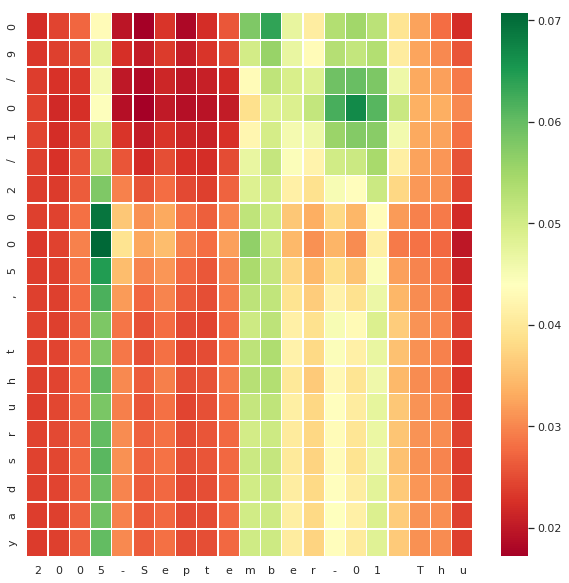

In [ ]:
example = [gen_date() for _ in range(1)]
plot_attention(model, example)